# Lecture 7
# The Mechanics of Learning

This week, we will study how exactly a machine learns to do something from a given training dataset. In particular, we will see how the following process will be applied to various learning tasks:
- Represent the task as a mathematical problem
- Specify a type of functions as the model
- Design a loss function to measure the performance of the model
- Design a training algorithm to optimize the model

*Readings: Chapter 5 (We will come back for Chapter 3 & 4 later)*

## A "Hot" Problem

Suppose the task is to discover the relationship between two metrics of temperature: Fahrenheit and an unknown unit. The temperature data we have is the following:

In [42]:
import torch

t_u = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_f = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

A quick plot of our data tells us that the relationship is noisy, but we think there is a pattern.

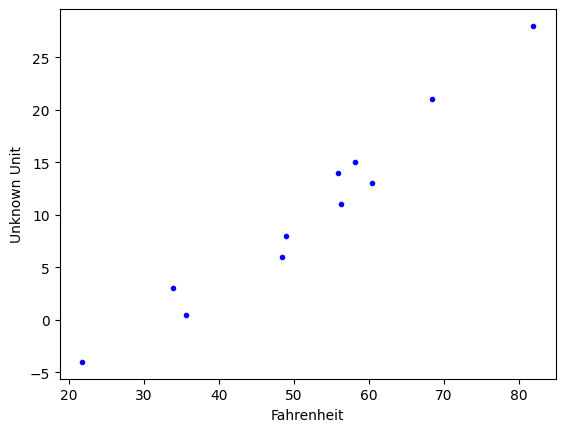

In [43]:
import matplotlib.pyplot as plt

plt.plot(t_f, t_u, 'b.')
plt.xlabel("Fahrenheit")
plt.ylabel("Unknown Unit")
plt.show()

In the absence of further knowledge, we assume the simaplest possible model for converting between the two sets of measurements:

- `t_u = w * t_f + b`

We know this relationship represents a straight line no matter what value `w` and `b` has. It means that we **proposed a linear model** to solve the task.

- We will refer to `w` as the **weight parameter**.
- We will refer to `b` as the **biase parameter**.
- We need to estimate `w` and `b` so that the predicted outputs and the measured values are as close as possible.
- **How do we measure the errors made by the model?**
- **How should we reduce the errors?**

## Loss Function
A **loss function** (or cost function) is a mathematical function that computes a single numerical value that the learning process will attempt to minimize. The calculation of loss typically involves taking the difference between the model predictions and the desired outputs.

- For the temperature conversion task, a reasonable measure of an individual error is `(prediction - t_u) ** 2`.
- The **mean-squared-error (MSE)** loss function is the average among all individual errors.
- The square is necessary because we don't want any cancellation between errors.
- The MSE loss has several advantages:
    - easy to calculate
    - differentiable everywhere
    - is a convex function

<img src="https://miro.medium.com/v2/resize:fit:1200/0*x4ksvqk4VobImk4C.jpg" height="300">

Next, let's find a reasonable value for `w` and `b`, and calcualte the model's MSE.

In [44]:
import numpy as np
# An example showing why the average error is not a good measure.
error1 = 102
error2 = -50
error3 = -52

(error1 + error2 + error3) / 3 # Answer: 0.0

# MSE:
(error1 ** 2 + error2 ** 2 + error3 ** 2) / 3 # Answer: 5202

# Can you propose a better measure of the average error?
# Mean Absolute Error

(np.abs(error1) + np.abs(error2) + np.abs(error3)) / 3

np.float64(68.0)

In [45]:
def model(t_f, w, b):
    return w * t_f + b

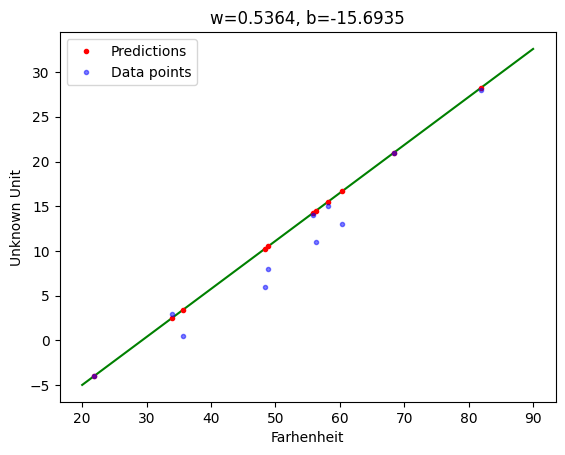

In [79]:
# The model looks reasonable if w and b take the following values
w = 0.5364
b = -15.6935

# Plot the line
x = torch.tensor([20, 90])
y = model(x, w, b)
plt.plot(x, y, 'g-')

# Calculate model predictions
t_p = model(t_f, w, b)
plt.plot(t_f, t_p, 'r.', label="Predictions")

plt.plot(t_f, t_u, 'b.', alpha=0.5, label="Data points")
plt.title(f"w={w}, b={b}")
plt.xlabel("Farhenheit")
plt.ylabel("Unknown Unit")
plt.legend()
plt.show()

In [47]:
def loss_fn(t_p, t_u):
    squared_errors = (t_p - t_u) ** 2
    return squared_errors.mean()

In [48]:
loss = loss_fn(t_p, t_u)
loss

tensor(5.4622)

In [49]:
torch.sqrt(loss) # It reflects an average error made by the model

tensor(2.3371)

## Reduce the Loss

The MSE for the model with current parameter values looks quite small, but can we do better? If possible, we would like to find the parameters values that **minimizes the loss**. How can we achieve that?

We will optimize the loss function with respect to the parameters using the **gradient descent** algorithm. The core steps are:
- Compute the rate of change of the loss with respect to each parameter
- Modify each parameter in the direction of decreasing loss.
- The rate of change can be estimated by adding a small number to `w` and `b` and see how much the loss changes in that neighborhood.

In [50]:
delta = 0.1 # a small number
loss_rate_of_change_w = \
    (loss_fn(model(t_f, w + delta, b), t_u) - \
     loss_fn(model(t_f, w - delta, b), t_u)) / (2.0 * delta)
loss_rate_of_change_w

tensor(164.7417)

This means that in the neighborhood of the current values of `w` and `b`, a small increate in `w` leads to an increase of the loss. Therefore, if we want to decrease the loss, we should reduce the value of `w`.

How much should `w` be decreased?
- It is a good idea to change `w` proportional to the rate of change.
- It is also wise to change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the current value.
- We typically should scale the rate of change by a small factor called **learning rate**.

In [51]:
learning_rate = 0.0001
w = w - learning_rate * loss_rate_of_change_w
w

tensor(0.5199)

We can do the same with `b`:

In [52]:
loss_rate_of_change_b = \
    (loss_fn(model(t_f, w, b + delta), t_u) - \
     loss_fn(model(t_f, w, b - delta), t_u)) / (2.0 * delta)
loss_rate_of_change_b

tensor(1.4773)

In [53]:
b = b - learning_rate * loss_rate_of_change_b
b

tensor(-15.6936)

In [54]:
t_p = model(t_f, w, b) # Prediction made by the new model
loss_fn(t_p, t_u)      # New loss

tensor(3.5461)

## Gradient Descent

The above approach of loss reduction doesn't scale well when there are a large number of parameters:
- Each rate of change requires at least two evaluations of the model function.
- It is not always clear how large the neighborhood should be.

As an improvement, we can use the derivatives instead:
- The derivative of a function is defined using a infinitesiamlly small neighborhood.
- The derivatives with respect to different parameters are related via the chain rule.
- All derivatives forms a vector called **the gradient**. The gradient vector indicates the direction where the function increases the fastest.
- If we modify the parameters in the opposite direction of the gradient, then the function value tends to decrease the fastest.

<img src="https://andymath.com/wp-content/uploads/2019/08/chain-rule.jpg" height="200">

<img src="https://github.com/ch00226855/temp/blob/main/.ipynb_checkpoints/GradientDescent.png?raw=true" height="500">

In [55]:
# Compute the derivatives
def dloss_fn(t_p, t_u):
    dsq_diffs = 2 * (t_p - t_u) / t_p.size(0)
    return dsq_diffs

In [56]:
def dmodel_dw(t_f, w, b):
    return t_u

In [57]:
def dmodel_db(t_f, w, b):
    return 1.0

<img src="https://github.com/ch00226855/temp/blob/main/.ipynb_checkpoints/ChainRule.png?raw=true" height="300">

In [58]:
def grad_fn(t_f, t_u, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_u)
    dloss_dw = dloss_dtp * dmodel_dw(t_f, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_f, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [59]:
# Example: What is the next update?
grad_fn(t_f, t_u, t_p, w, b)

tensor([4.9955, 1.4770])

## Iterating to Fit the Model

We now have everything in place to optimize the model parameters. Starting from a tentative value for a parameter, we can iteratively apply updates to it so that the model can be continuously improved.

In [60]:
def training_loop(n_epochs, learning_rate, params, t_f, t_u,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_f, w, b)
        loss = loss_fn(t_p, t_u)
        grad = grad_fn(t_u, t_u, t_p, w, b)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000, 6000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break

    return params

In [61]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2, # 1e-2 = 0.01
    params = torch.tensor([1.0, 0.0]),
    t_f = t_f,
    t_u = t_u)

Epoch 1, Loss 1763.884644
    Params: tensor([-8.8953, -0.8260])
    Grad:   tensor([989.5273,  82.6000])
Epoch 2, Loss 245795.640625
    Params: tensor([116.3841,   8.6160])
    Grad:   tensor([-12527.9385,   -944.2022])
Epoch 3, Loss 39779068.000000
    Params: tensor([-1469.5060,  -111.9202])
    Grad:   tensor([158589.0156,  12053.6250])
...
Epoch 10, Loss 107871650419459624009728.000000
    Params: tensor([7.6566e+10, 5.8159e+09])
    Grad:   tensor([-8.2615e+12, -6.2753e+11])
Epoch 11, Loss 17286328579322760134656000.000000
    Params: tensor([-9.6925e+11, -7.3623e+10])
    Grad:   tensor([1.0458e+14, 7.9439e+12])
...


tensor([-3.9886e+18, -3.0297e+17])

Something strange happend. The loss value actually blew up to infinity. This happened becasue the parameter updates are too large:

<img src="https://github.com/ch00226855/temp/blob/main/.ipynb_checkpoints/LossBlowUp.png?raw=true" height="300">

In [62]:
# Modify the training process to actually reduce the loss.
training_loop(
    n_epochs = 5000,
    learning_rate = 0.00031, #0.0001
    # params = torch.tensor([1.0, 0.0]),
    params = torch.tensor([0.5364, -15.6935]),
    t_f = t_f,
    t_u = t_u)

Epoch 1, Loss 5.462214
    Params: tensor([  0.5279, -15.6945])
    Grad:   tensor([27.4743,  3.1840])
Epoch 2, Loss 4.270157
    Params: tensor([  0.5230, -15.6952])
    Grad:   tensor([15.8338,  2.2997])
Epoch 3, Loss 3.777485
    Params: tensor([  0.5201, -15.6958])
    Grad:   tensor([9.1222, 1.7898])
...
Epoch 10, Loss 3.341529
    Params: tensor([  0.5164, -15.6984])
    Grad:   tensor([0.1767, 1.1093])
Epoch 11, Loss 3.338584
    Params: tensor([  0.5164, -15.6988])
    Grad:   tensor([0.0948, 1.1029])
...
Epoch 99, Loss 3.323482
    Params: tensor([  0.5168, -15.7285])
    Grad:   tensor([-0.0166,  1.0824])
Epoch 100, Loss 3.323354
    Params: tensor([  0.5168, -15.7288])
    Grad:   tensor([-0.0166,  1.0823])
...
Epoch 4000, Loss 3.041892
    Params: tensor([  0.5327, -16.7634])
    Grad:   tensor([-0.0103,  0.6634])
Epoch 5000, Loss 3.013539
    Params: tensor([  0.5357, -16.9566])
    Grad:   tensor([-0.0090,  0.5851])


tensor([  0.5357, -16.9566])

The loss reduction is now stable, but it is too slow. **Adjust the learning rate to achieve a better result**.

In [63]:
# Adjust the learning rate to achieve a better result.



We observe that the starting gradient of `w` is much larger than that of `b`. This means that the weight and bias live in different spaces, and it is impossible for a single learning rate to best serve them both.

We could have individual learning rates for each parameter, but a better idea is to **normalize** all input features to the same scale.

In [64]:
t_fn = 0.1 * t_f

In [65]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    # params = torch.tensor([ 5.3676, -17.3042]),
    t_f = t_fn,
    t_u = t_u)

Epoch 1, Loss 80.364342
    Params: tensor([3.3834, 0.1064])
    Grad:   tensor([-238.3427,  -10.6400])
Epoch 2, Loss 63.942089
    Params: tensor([ 2.4928, -0.0363])
    Grad:   tensor([89.0627, 14.2651])
Epoch 3, Loss 29.862780
    Params: tensor([ 2.8472, -0.0838])
    Grad:   tensor([-35.4412,   4.7529])
...
Epoch 10, Loss 32.474255
    Params: tensor([ 2.8309, -0.5984])
    Grad:   tensor([-1.0661,  7.1644])
Epoch 11, Loss 32.217278
    Params: tensor([ 2.8421, -0.6697])
    Grad:   tensor([-1.1162,  7.1316])
...
Epoch 99, Loss 16.810717
    Params: tensor([ 3.6567, -5.9470])
    Grad:   tensor([-0.7734,  5.0099])
Epoch 100, Loss 16.692223
    Params: tensor([ 3.6644, -5.9969])
    Grad:   tensor([-0.7703,  4.9899])
...
Epoch 4000, Loss 3.043108
    Params: tensor([  5.5794, -18.4015])
    Grad:   tensor([-1.1921e-05,  9.3639e-05])
Epoch 5000, Loss 3.043108
    Params: tensor([  5.5794, -18.4015])
    Grad:   tensor([-1.1921e-05,  9.3639e-05])


In [66]:
# Ex: How much can you reduce the loss?



## Visualize the Training Process
It is helpful to visualize the training process so that we can monitor it.

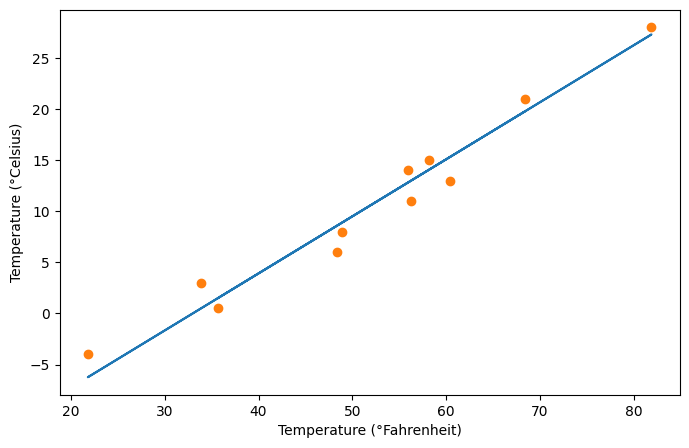

In [67]:
from matplotlib import pyplot as plt

t_p = model(t_fn, *params)

fig = plt.figure(figsize=(8, 5))
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_f.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_f.numpy(), t_u.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")

## Calcuate the Gradient with PyTorch

PyTorch offers a function called `autograd` to automatically calculate the gradient. The underlying algorithm is **back propogation**, which is based on the chain rule.

In [68]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [69]:
# Associate parameters with a function.
loss = loss_fn(model(t_f, *params), t_u)
# params.requires_grad_(True) # We can turn on requires_grad after definition.
loss.backward()

params.grad

tensor([4517.2964,   82.6000])

In [70]:
# Verify the gradients
t_p = model(t_f, *params)
w = params[0]
b = params[1]
grad_fn(t_f, t_u, t_p, w, b)

tensor([989.5273,  82.6000], grad_fn=<StackBackward0>)

In [71]:
def training_loop(n_epochs, learning_rate, params, t_f, t_u):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_f, *params)
        loss = loss_fn(t_p, t_u)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [72]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_f = t_fn,
    t_u = t_u)

Epoch 500, Loss 7.860118
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927831
Epoch 4000, Loss 2.927680
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## Gradient Descent with PyTorch

PyTorch provides a list of optimization functions, including the vanilla gradient descent method and its variants.

In [73]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adafactor',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_adafactor',
 '_functional',
 'lr_scheduler',
 'swa_utils']

In [74]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [75]:
t_p = model(t_f, *params)
loss = loss_fn(t_p, t_u)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [76]:
def training_loop(n_epochs, optimizer, params, t_f, t_u):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_u)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [77]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_f = t_fn,
    t_u = t_u)

Epoch 500, Loss 0.008931
Epoch 1000, Loss 0.000208
Epoch 1500, Loss 0.000006
Epoch 2000, Loss 0.000001
Epoch 2500, Loss 0.000001
Epoch 3000, Loss 0.000001
Epoch 3500, Loss 0.000001
Epoch 4000, Loss 0.000001
Epoch 4500, Loss 0.000001
Epoch 5000, Loss 0.000001


tensor([0.9999, 0.0016], requires_grad=True)

In [78]:
# Let's try the ADAM optimizer
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1 # 1e-1 means 1 * (10 ** -1) = 0.1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    t_f = t_f,
    t_u = t_u)

Epoch 500, Loss 0.000000
Epoch 1000, Loss 0.000000
Epoch 1500, Loss 0.000000
Epoch 2000, Loss 0.000000
Epoch 2500, Loss 0.000000
Epoch 3000, Loss 0.000000


tensor([1., 0.], requires_grad=True)